# S8 WESAD XGBoost

    Female Participant
    Age: 27
    Height (cm): 172
    Weight (kg): 64
    Note: cold during stress

# Load Tools

In [2]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.utils import class_weight
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier

In [4]:
# Visualizing High-Performance Gradient Boosting with XGBoost and Yellowbrick
# https://rebeccabilbro.github.io/xgboost-and-yellowbrick/
# conda install -c districtdatalabs yellowbrick
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

In [5]:
sns.set(style="darkgrid")

In [6]:
import autoreload
%load_ext watermark
%load_ext autoreload
%autoreload 2
%watermark -a 'WForsythe' -d -t -v -p   numpy,pandas,cv2,xgboost,sklearn,seaborn,matplotlib,yellowbrick

WForsythe 2020-07-29 14:49:55 

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
pandas 1.0.3
cv2 4.2.0
xgboost 1.0.2
sklearn 0.22.1
seaborn 0.9.0
matplotlib 3.2.2
yellowbrick 1.1


# Load and Process File

## Load File

In [7]:
data = 'D:/WESAD/'
s8_file = pd.read_pickle(data + 'S8/S8.pkl')
s8_file

Wall time: 4.81 s


{'signal': {'chest': {'ACC': array([[ 8.74600053e-01, -2.31999755e-02,  2.76200056e-01],
          [ 8.80200028e-01, -1.13999844e-02,  2.63800025e-01],
          [ 8.86999965e-01,  2.00033188e-04,  2.38199949e-01],
          ...,
          [ 9.13800001e-01, -4.99999523e-03, -6.01999760e-02],
          [ 9.13800001e-01, -5.80000877e-03, -5.86000085e-02],
          [ 9.14600015e-01, -7.20000267e-03, -6.26000166e-02]]),
   'ECG': array([[ 0.16950989],
          [ 0.16639709],
          [ 0.16337585],
          ...,
          [-0.02183533],
          [-0.01629639],
          [-0.00823975]]),
   'EMG': array([[-0.00535583],
          [ 0.00993347],
          [ 0.01478577],
          ...,
          [-0.00119019],
          [-0.0100708 ],
          [-0.00979614]]),
   'EDA': array([[4.36859131],
          [4.37202454],
          [4.38194275],
          ...,
          [3.51028442],
          [3.50608826],
          [3.50456238]]),
   'Temp': array([[34.264893],
          [34.28018 ],
         

**there are 3 columns for both chest and wrist ACC and one column each for the other features**

## Process

### Seperate chest features  from wrist  features 

In [8]:
cax = s8_file['signal']['chest']['ACC'][0:,0]
cay = s8_file['signal']['chest']['ACC'][0:,1]
caz = s8_file['signal']['chest']['ACC'][0:,2]
cecg = s8_file['signal']['chest']['ECG'][:,0]
cemg = s8_file['signal']['chest']['EMG'][:,0]
ceda = s8_file['signal']['chest']['EDA'][:,0]
ctemp = s8_file['signal']['chest']['Temp'][:,0]
cresp = s8_file['signal']['chest']['Resp'][:,0]
label = s8_file['label']

In [9]:
label

array([0, 0, 0, ..., 0, 0, 0])

### Change dictionary object to a numpy array and array to a dataframe

In [10]:
# Python | Numpy ndarray.T
# https://www.geeksforgeeks.org/python-numpy-ndarray-t/
# Numpy Array Cookbook: Generating and Manipulating Arrays in Python
# https://towardsdatascience.com/numpy-array-cookbook-generating-and-manipulating-arrays-in-python-2195c3988b09

In [11]:
chest = [cax, cay, caz, cecg, cemg, 
         ceda, ctemp, cresp, label] 
ch_array = np.array(chest) 
ch_array = ch_array.T # transpose 
Columns = ['cax', 'cay', 'caz','cecg', 'cemg', 
          'ceda','ctemp', 'cresp', 'label' ]
ch_df = pd.DataFrame(ch_array, columns = Columns) 
ch_df

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.8746,-0.0232,0.2762,0.169510,-0.005356,4.368591,34.264893,-1.718140,0.0
1,0.8802,-0.0114,0.2638,0.166397,0.009933,4.372025,34.280182,-1.716614,0.0
2,0.8870,0.0002,0.2382,0.163376,0.014786,4.381943,34.263397,-1.705933,0.0
3,0.8954,0.0176,0.2030,0.153259,0.015884,4.365921,34.271027,-1.710510,0.0
4,0.9002,0.0326,0.1486,0.147629,0.028381,4.366684,34.261841,-1.713562,0.0
...,...,...,...,...,...,...,...,...,...
3826195,0.9150,-0.0078,-0.0558,-0.022842,0.006363,3.517151,35.528717,0.733948,0.0
3826196,0.9160,-0.0082,-0.0586,-0.024216,0.002335,3.516388,35.519409,0.730896,0.0
3826197,0.9138,-0.0050,-0.0602,-0.021835,-0.001190,3.510284,35.432373,0.727844,0.0
3826198,0.9138,-0.0058,-0.0586,-0.016296,-0.010071,3.506088,35.547394,0.703430,0.0


#### Check Statistics

In [12]:
ch_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,3826200.0,0.824711,0.089931,-0.473400,0.780200,0.842600,0.897000,2.328600
cay,3826200.0,-0.087701,0.134317,-0.775800,-0.179600,-0.070600,0.001800,0.640800
caz,3826200.0,-0.270723,0.293661,-1.798400,-0.491400,-0.307000,-0.041800,2.261800
cecg,3826200.0,0.001477,0.266321,-1.440353,-0.077042,-0.017899,0.017624,1.499954
cemg,3826200.0,-0.002612,0.019346,-1.250198,-0.010025,-0.002060,0.005081,1.031433
ceda,3826200.0,3.782816,0.192292,3.295898,3.669357,3.759384,3.854752,5.717850
ctemp,3826200.0,35.014137,0.311258,33.630707,34.861572,35.017365,35.201355,35.776520
cresp,3826200.0,0.067162,3.574538,-24.359131,-1.795959,-0.077820,1.976013,22.613525
label,3826200.0,1.412002,1.635803,0.000000,0.000000,1.000000,2.000000,7.000000


#### Check Type

In [13]:
print(ch_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3826200 entries, 0 to 3826199
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   cax     float64
 1   cay     float64
 2   caz     float64
 3   cecg    float64
 4   cemg    float64
 5   ceda    float64
 6   ctemp   float64
 7   cresp   float64
 8   label   float64
dtypes: float64(9)
memory usage: 262.7 MB
None


### Concatenate classes 0, 1, 2, 3, and 4

In [15]:
loc0 = ch_df.loc[ch_df['label'] == 0]
loc1 = ch_df.loc[ch_df['label'] == 1]
loc2 = ch_df.loc[ch_df['label'] == 2]
loc3 = ch_df.loc[ch_df['label'] == 3]
loc4 = ch_df.loc[ch_df['label'] == 4]

In [16]:
ch_loc = pd.concat([loc0, loc1, loc2, loc3, loc4])
ch_loc

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,0.8746,-0.0232,0.2762,0.169510,-0.005356,4.368591,34.264893,-1.718140,0.0
1,0.8802,-0.0114,0.2638,0.166397,0.009933,4.372025,34.280182,-1.716614,0.0
2,0.8870,0.0002,0.2382,0.163376,0.014786,4.381943,34.263397,-1.705933,0.0
3,0.8954,0.0176,0.2030,0.153259,0.015884,4.365921,34.271027,-1.710510,0.0
4,0.9002,0.0326,0.1486,0.147629,0.028381,4.366684,34.261841,-1.713562,0.0
...,...,...,...,...,...,...,...,...,...
3704767,0.6554,0.0192,-0.6834,0.478180,-0.015289,3.532410,35.581635,2.293396,4.0
3704768,0.6538,0.0200,-0.6806,0.262756,-0.003937,3.532791,35.511627,2.265930,4.0
3704769,0.6542,0.0222,-0.6806,0.103363,0.004532,3.535461,35.586304,2.253723,4.0
3704770,0.6532,0.0222,-0.6818,-0.013000,-0.007095,3.535461,35.597229,2.250671,4.0


#### Check Statistics

In [17]:
ch_loc.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,3719799.0,0.822315,0.090039,-0.473400,0.778600,0.837800,0.894000,2.328600
cay,3719799.0,-0.088365,0.136074,-0.775800,-0.182400,-0.069000,0.003000,0.640800
caz,3719799.0,-0.276392,0.295248,-1.798400,-0.499800,-0.324600,-0.047000,2.261800
cecg,3719799.0,0.001470,0.266494,-1.440353,-0.077316,-0.018036,0.017532,1.499954
cemg,3719799.0,-0.002611,0.019383,-1.250198,-0.010025,-0.002060,0.004990,1.031433
ceda,3719799.0,3.782342,0.194464,3.295898,3.664398,3.757858,3.853989,5.717850
ctemp,3719799.0,35.012175,0.315127,33.630707,34.853912,35.014282,35.205963,35.776520
cresp,3719799.0,0.066212,3.587294,-24.359131,-1.789856,-0.057983,1.991272,22.613525
label,3719799.0,1.280203,1.452146,0.000000,0.000000,1.000000,2.000000,4.000000


#### Plot all classes vs. classes 0,1,2,3,4 

3826200 3719799
Number of Rows Removed: 106401


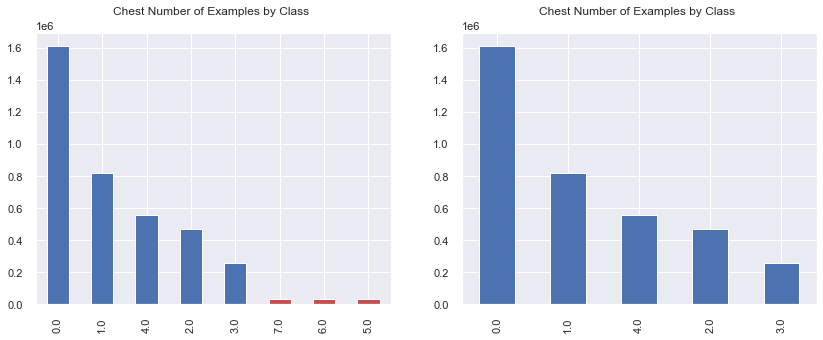

In [18]:
sns.set(style="darkgrid")
plt.figure(figsize = (14,5))
plt.subplot(1, 2, 1)
ch_df['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n',
                                     color=['b','b','b','b','b','r','r','r'])
plt.subplot(1, 2, 2)
ch_loc['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n')
print((ch_df['label'].value_counts().sum()), ch_loc['label'].value_counts().sum())
print('Number of Rows Removed:', (ch_df['label'].value_counts().sum()) - 
      ch_loc['label'].value_counts().sum());

**XGBoost for Multi-class Classification** <br>
https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

In [1]:
# Multiclass ROC AUC Score original script sourced from 
'''
Author: Plog, E
Title: AUC ROC Curve Scoring Function for Multi-class Classification
Date: 2018
Code version: n.a.
Availability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
'''

'\nAuthor: Plog, E\nTitle: AUC ROC Curve Scoring Function for Multi-class Classification\nDate: 2018\nCode version: n.a.\nAvailability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659\n'

# Model Runs: XGBoost Classifier

## All Chest

### Train Test

In [21]:
y = ch_loc.label
x = ch_loc.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)
evalSet = [(x_train, y_train), (x_test, y_test)]

(2975839, 8)
(743960,)


### Check Correlations

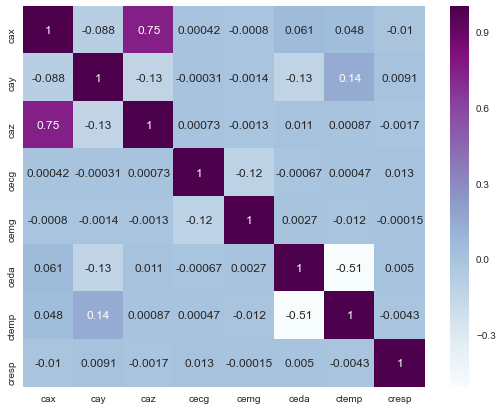

In [22]:
plt.figure(figsize=(9,7))
sns.heatmap(x_train.corr(), annot=True, cmap=plt.cm.BuPu);

There is only one strong correlation - cax and caz - where the x-axis is forward/back and the z-axis is up/down.<br>
This makes sense considering that movement from standing to sitting or from sitting to standing would likely involve x-axis motion 

### Model Fit and f1 and Balanced Accuracy Scores

In [23]:
%%time
allChest = xgb.XGBClassifier(objective = 'multi:softmax',
                              tree_method = 'gpu_hist',
                              learning_rate = 0.1,
                              n_estimators = 300, 
                              max_depth = 10,
                              #deterministic_histogram = 'false',
                              gradient_based = 0.1,
                              num_early_stopping_rounds = 20,
                              gamma = 3,
                              seed = 24,
                              verbosity = 2) 

model_allChest = allChest.fit(x_train,y_train) # , class_weight=class_weights
allChest_pred = allChest.predict(x_test)
allChest_report = (classification_report(y_test,
                                         allChest_pred,
                                         labels=np.unique(allChest_pred),
                                         digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, allChest_pred))
print('----------------------------------------')
print('------------ S8 All Chest Classification Report------------')
print(allChest_report)

Balanced Accuracy: 0.9924485846269185
----------------------------------------
------------ S11 All Chest Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9932    0.9873    0.9903    323786
         1.0     0.9949    0.9981    0.9965    163444
         2.0     0.9865    0.9920    0.9893     93335
         3.0     0.9828    0.9908    0.9868     51852
         4.0     0.9901    0.9940    0.9920    111543

    accuracy                         0.9915    743960
   macro avg     0.9895    0.9924    0.9910    743960
weighted avg     0.9915    0.9915    0.9915    743960

Wall time: 1min 35s


### Confusion Matrix

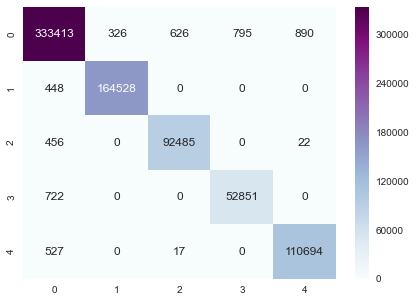

In [23]:
cm = confusion_matrix(y_test, allChest_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Class Prediction Error

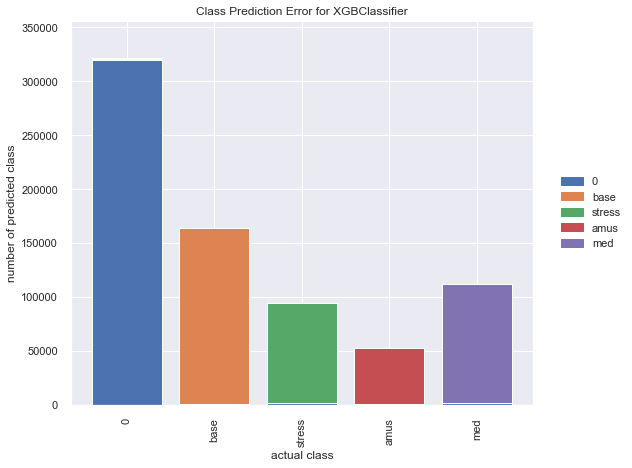

In [27]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(allChest, size=(720, 480), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

    Class prediction error appears to be minimal

### Multi-class AUC Score

In [26]:
def multiclass_roc_auc_score(y_test, allChest_pred, average = 'micro'): 
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(allChest_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, allChest_pred)

print('S8 All Chest')
print('---------------------')
print("AUC: %.2f%%" % (aucScore*100))

S11 All Chest
---------------------
AUC: 99.60%


### Feature Importance

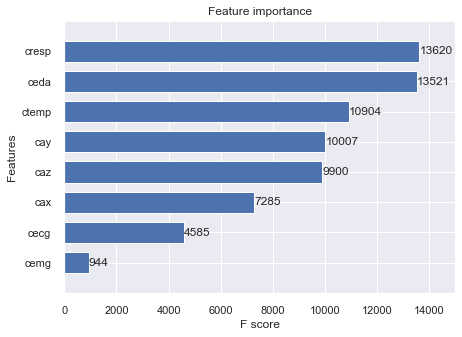

In [28]:
# ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
plt.rcParams["figure.figsize"] = (7, 5) 
plot_importance(model_allChest, importance_type = 'weight', height = 0.7);

## Chest Less Accelerometer 

### Train Test Split

In [39]:
lessAcc = ch_loc[['ceda', 'ctemp', 'cresp', 'cemg', 'cecg', 'label']]
y = lessAcc.label
x = lessAcc.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(2975839, 5)
(743960,)


### Model Fit and f1 and Balanced Accuracy Scores

In [40]:
%%time
ch_lessAcc = XGBClassifier(objective = 'multi:softmax',
                              tree_method = 'gpu_hist',
                              learning_rate = 0.1,
                              n_estimators = 200, 
                              #max_depth = 10,
                              #deterministic_histogram = 'false',
                              gradient_based = 0.1,
                              num_early_stopping_rounds = 20,
                              gamma = 3,
                              #seed = 24,
                              verbosity = 2) 

model_ch_lessAcc = ch_lessAcc.fit(x_train,y_train)
ch_lessAcc_pred = ch_lessAcc.predict(x_test)
ch_lessAcc_report = (classification_report(y_test,
                                           ch_lessAcc_pred,
                                           labels=np.unique(ch_lessAcc_pred),
                                           digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, ch_lessAcc_pred))
print('----------------------------------------')
print('------------ S8 All Chest less ACC Classification Report------------')
print(ch_lessAcc_report)

Balanced Accuracy: 0.7963935898263239
----------------------------------------
------------ S11 All Chest less ACC Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9158    0.8924    0.9039    323279
         1.0     0.8561    0.9419    0.8970    164184
         2.0     0.8331    0.7796    0.8055     93657
         3.0     0.6337    0.5077    0.5638     51628
         4.0     0.8020    0.8604    0.8302    111212

    accuracy                         0.8576    743960
   macro avg     0.8082    0.7964    0.8001    743960
weighted avg     0.8556    0.8576    0.8554    743960

Wall time: 59.3 s


### Confusion Matrix

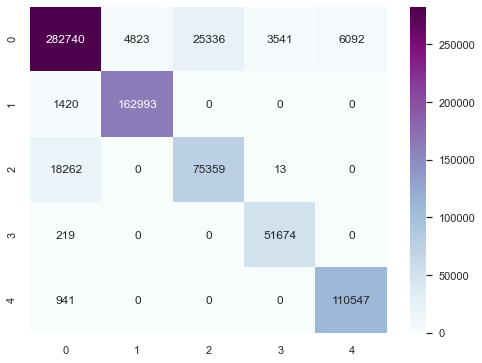

In [46]:
cm = confusion_matrix(y_test, ACC_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Classification Prediction Error

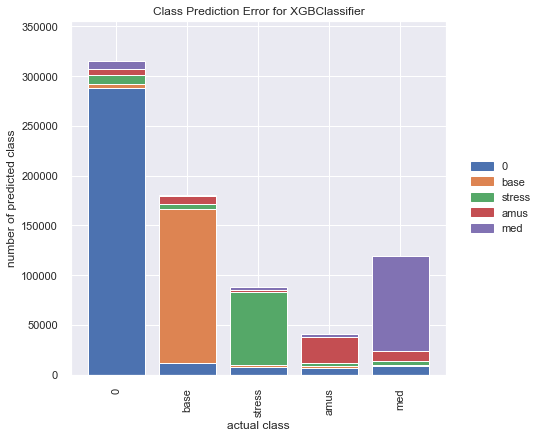

In [42]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(ch_lessAcc, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

### Multiclass ROC AUC Score

In [43]:
def multiclass_roc_auc_score(y_test, ch_lessAcc_pred, average = 'micro'): 
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(ch_lessAcc_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, ch_lessAcc_pred)

print('S8 All Chest less ACC')
print('-------------------------------')
print("AUC: %.2f%%" % (aucScore*100))

S11 All Chest less ACC
-------------------------------
AUC: 91.10%


##  Accelerator [X,Y,Z] 

### Train Test Split

In [44]:
ch_ACC = ch_loc[['cax', 'cay', 'caz', 'label']]
y = ch_ACC.label
x = ch_ACC.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(2975839, 3)
(743960,)


### Model Fit and f1 and Balanced Accuracy Scores

In [45]:
%%time
ACC = XGBClassifier(objective = 'multi:softmax',
                           tree_method = 'gpu_hist',
                           learning_rate = 0.1,
                           gradient_based = 0.1,
                           num_early_stopping_rounds = 20,
                           n_estimators = 200,
                           gamma = 3,
                           verbosity = 2) 

model_ACC = ACC.fit(x_train, y_train)
ACC_pred = ACC.predict(x_test)
ACC_report = (classification_report(y_test, 
                                         ACC_pred, 
                                         labels=np.unique(ACC_pred),
                                         digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, ACC_pred))
print('---------------------------------------')
print('------------ S8 Chest ACC Classification Report------------')
print(ACC_report)

Balanced Accuracy: 0.932030797260164
---------------------------------------
------------ S11 Chest ACC Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9313    0.8766    0.9032    322532
         1.0     0.9713    0.9914    0.9812    164413
         2.0     0.7484    0.8048    0.7756     93634
         3.0     0.9356    0.9958    0.9648     51893
         4.0     0.9478    0.9916    0.9692    111488

    accuracy                         0.9185    743960
   macro avg     0.9069    0.9320    0.9188    743960
weighted avg     0.9199    0.9185    0.9185    743960

Wall time: 49.4 s


### Confusion matrix 

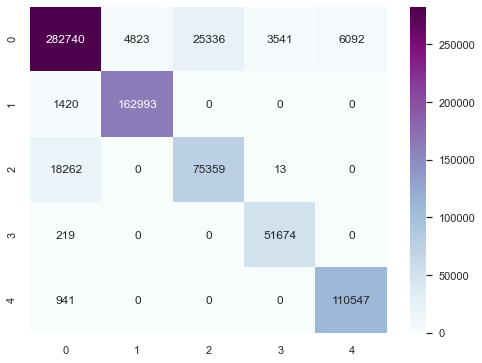

In [46]:
cm = confusion_matrix(y_test, ACC_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Classification Prediction Error

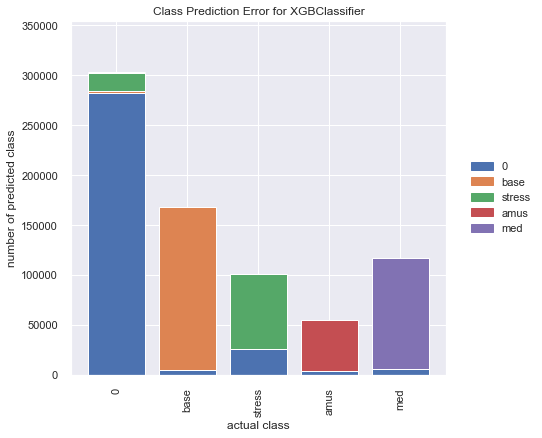

In [47]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(ACC, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

### Multiclass ROC AUC Score

In [48]:
def multiclass_roc_auc_score(y_test, ACC_pred, average = 'macro'): #(None, 'micro', 'macro', 'weighted', 'samples')
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(ACC_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, ACC_pred)

print('S11 Chest Accelerometer')
print('-------------------')
print("AUC: %.2f%%" % (aucScore*100))  

S11 Chest Accelerometer
-------------------
AUC: 95.49%


## Chest EDA

In [19]:
ch_eda= ch_loc[['ceda', 'label']]
y = ch_eda.label
x = ch_eda.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(2975839, 1)
(743960,)


In [20]:
%%time
Eda = XGBClassifier(objective = 'multi:softmax',
                    tree_method = 'gpu_hist',
                    learning_rate = 0.1,
                    gradient_based = 0.1,
                    max_depth = 10,
                    num_early_stopping_rounds = 20,
                    n_estimators = 300,
                    gamma = 3,
                    verbosity = 2) 

model_Eda = Eda.fit(x_train, y_train)
Eda_pred = Eda.predict(x_test)
Eda_report = (classification_report(y_test, 
                                         Eda_pred, 
                                         labels = np.unique(Eda_pred),
                                         digits = 4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, Eda_pred))
print('---------------------------------------')
print('------------ S8 Chest Electrodermal Activity Classification Report------------')
print(Eda_report)

Balanced Accuracy: 0.49494738172479824
---------------------------------------
------------ S8 Chest Electrodermal Activity Classification Report------------
              precision    recall  f1-score   support

         0.0     0.7480    0.7408    0.7444    322929
         1.0     0.5545    0.8051    0.6567    163668
         2.0     0.3591    0.2348    0.2840     94212
         4.0     0.6187    0.6940    0.6542    111372

   micro avg     0.6323    0.6796    0.6551    692181
   macro avg     0.5701    0.6187    0.5848    692181
weighted avg     0.6285    0.6796    0.6465    692181

Wall time: 1min 5s


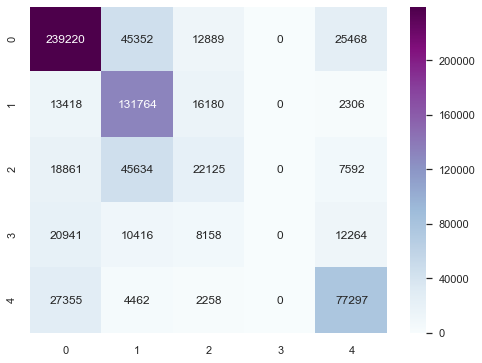

In [21]:
cm = confusion_matrix(y_test, Eda_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

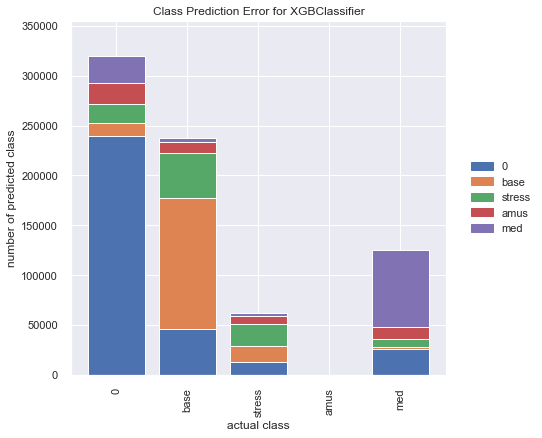

In [22]:
Classes = ['0', 'base', 'stress', 'amus', 'med']
error = ClassPredictionError(Eda, size=(620, 450), classes=Classes)
error.score(x_test, y_test)
e = error.poof()

In [23]:
def multiclass_roc_auc_score(y_test, Eda_pred, average = 'macro'): #(None, 'micro', 'macro', 'weighted', 'samples')
    xg = preprocessing.LabelBinarizer()
    xg.fit(y_test)
    y_test1 = xg.transform(y_test) 
    y_pred1 = xg.transform(Eda_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore = multiclass_roc_auc_score(y_test, Eda_pred)

print('S11 Chest Skin Temperature')
print('-------------------')
print("AUC: %.2f%%" % (aucScore*100))  

S11 Chest Skin Temperature
-------------------
AUC: 69.65%
